## Data Preprocessing for the MICCAI 2020 HEad and neCK TumOR segmentation challenge [(HECKTOR)](https://www.aicrowd.com/challenges/miccai-2020-hecktor)

In [1]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from src.data.utils import read_nifti, write_nifti, get_attributes, resample_sitk_image

### Summary:

Dataset:
- Each data sample (patient) consists of PET & CT images and a GTVt (primary Gross Tumor Volume) mask provided in NIfTI format.
- PET & CT images for a single patient might occupy different regions in physical space, i.e., the images have a different size (number of pixels per dimension), origin, spacing and direction cosine matrix (axis directions in physical space).
- For each case, a bounding box of the size of 144x144x144 mm is available. Segmentation must be performed within the bounding box. 

This notebook shows the way to transform (resample) a pair of PET & CT images for each patient to a common reference space and to extract a region of interest (a bounding box). Transformed images will be saved in NIfTI format.

**From now onward, the train set preprocessing will be demonstrated. For the test set preprocessing, all operations with ground truth labels (segmentation masks) must be omitted.**

#### Input / Output paths:

In [2]:
path_to_input = pathlib.Path('C:/inserm/hecktor/hecktor_train/hecktor_nii/')
path_to_bb = pathlib.Path('C:/inserm/hecktor/hecktor_train/bbox.csv')

path_to_output = pathlib.Path('C:/inserm/hecktor/hecktor_train/hecktor_nii_resampled/')

#### Bounding boxes:

In [3]:
bb = pd.read_csv(path_to_bb)
bb.head()

,PatientID,x1,x2,y1,y2,z1,z2
0,CHGJ007,-65.039062,75.585938,-166.992188,-26.367188,-204.050262,-60.170746
1,CHGJ008,-65.039062,75.585938,-166.992188,-26.367188,-460.319519,-316.438660
2,CHGJ010,-72.070312,68.554688,-135.351562,5.273438,-232.130219,-88.250702
3,CHGJ013,-75.585938,65.039062,-152.929688,-12.304688,-242.630219,-98.750702
4,CHGJ015,-65.039062,75.585938,-152.929688,-12.304688,-243.780273,-99.900757


In [4]:
patients = list(bb.PatientID)
print(f'Total number of patients: {len(patients)}')

Total number of patients: 201


In [5]:
n = -1
print(f'Available data for the patient {patients[n]}:')
print(os.listdir(path_to_input / patients[n]))

Available data for the patient CHUS101:
['CHUS101_ct.nii.gz', 'CHUS101_ct_gtvt.nii.gz', 'CHUS101_pt.nii.gz']


####  Extract patches and resample:

In [6]:
print(f'Resampled images will be saved in {path_to_output}')

if not os.path.exists(path_to_output):
    os.makedirs(path_to_output, exist_ok=True)

Resampled images will be saved in C:\inserm\hecktor\hecktor_train\hecktor_nii_resampled


In [7]:
for p in tqdm(patients):
    # Read images:
    img_ct = read_nifti(path_to_input / p / (p + '_ct.nii.gz'))
    img_pt = read_nifti(path_to_input / p / (p + '_pt.nii.gz'))
    mask = read_nifti(path_to_input / p / (p + '_ct_gtvt.nii.gz'))
    
    # Get bounding boxes:
    pt1 = bb.loc[bb.PatientID == p, ['x1', 'y1', 'z1']]
    pt2 = bb.loc[bb.PatientID == p, ['x2', 'y2', 'z2']]
    pt1, pt2 = tuple(*pt1.values), tuple(*pt2.values)
    
    # Convert physcial points into array indexes:
    pt1_ct = img_ct.TransformPhysicalPointToIndex(pt1)
    pt1_pt = img_pt.TransformPhysicalPointToIndex(pt1)
    pt1_mask = mask.TransformPhysicalPointToIndex(pt1)

    pt2_ct = img_ct.TransformPhysicalPointToIndex(pt2)
    pt2_pt = img_pt.TransformPhysicalPointToIndex(pt2)
    pt2_mask = mask.TransformPhysicalPointToIndex(pt2)
    
    # Exctract the patch:
    cr_img_ct = img_ct[pt1_ct[0]: pt2_ct[0], pt1_ct[1]: pt2_ct[1], pt1_ct[2]: pt2_ct[2]]
    cr_img_pt = img_pt[pt1_pt[0]: pt2_pt[0], pt1_pt[1]: pt2_pt[1], pt1_pt[2]: pt2_pt[2]]
    cr_mask = mask[pt1_mask[0]: pt2_mask[0], pt1_mask[1]: pt2_mask[1], pt1_mask[2]: pt2_mask[2]]
        
    # Resample all images using CT attributes:
    # CT:
    cr_img_ct = resample_sitk_image(cr_img_ct, 
                                    new_spacing=[1, 1, 1],
                                    new_size=[144, 144, 144],
                                    interpolator=sitk.sitkLinear)
    target_size = list(cr_img_ct.GetSize())
    attributes = get_attributes(cr_img_ct)
    
    # PT:
    cr_img_pt = resample_sitk_image(cr_img_pt, 
                                    new_spacing=[1, 1, 1], 
                                    new_size=target_size, 
                                    attributes=attributes,
                                    interpolator=sitk.sitkLinear)
    
    # Mask:
    cr_mask = resample_sitk_image(cr_mask, 
                                  new_spacing=[1, 1, 1], 
                                  new_size=target_size, 
                                  attributes=attributes,
                                  interpolator=sitk.sitkNearestNeighbor)
    
    # Save resampled images:
    if not os.path.exists(path_to_output / p):
        os.makedirs(path_to_output / p, exist_ok=True)
    
    write_nifti(cr_img_ct, path_to_output / p / (p + '_ct.nii.gz'))
    write_nifti(cr_img_pt, path_to_output / p / (p + '_pt.nii.gz'))
    write_nifti(cr_mask, path_to_output / p / (p + '_ct_gtvt.nii.gz'))

####  Check resampled images:

In [8]:
n = 0
p = patients[n]

img_ct = read_nifti(path_to_output / p / (p + '_ct.nii.gz'))
img_pt = read_nifti(path_to_output / p / (p + '_pt.nii.gz'))
mask = read_nifti(path_to_output / p / (p + '_ct_gtvt.nii.gz'))

In [9]:
print(f'SIZE:')
print(f'CT: \t{img_ct.GetSize()} \nPET: \t{img_pt.GetSize()} \nMask: \t{mask.GetSize()}')
print('-' * 40)
print(f'SPACING:')
print(f'CT: \t{img_ct.GetSpacing()} \nPET: \t{img_pt.GetSpacing()} \nMask: \t{mask.GetSpacing()}') 
print('-' * 40)
print(f'ORIGIN:')
print(f'CT: \t{img_ct.GetOrigin()} \nPET: \t{img_pt.GetOrigin()} \nMask: \t{mask.GetOrigin()}') 
print('-' * 40)
print(f'DIRECTION:')
print(f'CT: \t{img_ct.GetDirection()} \nPET: \t{img_pt.GetDirection()} \nMask: \t{mask.GetDirection()}') 

SIZE:
CT: 	(144, 144, 144) 
PET: 	(144, 144, 144) 
Mask: 	(144, 144, 144)
----------------------------------------
SPACING:
CT: 	(1.0, 1.0, 1.0) 
PET: 	(1.0, 1.0, 1.0) 
Mask: 	(1.0, 1.0, 1.0)
----------------------------------------
ORIGIN:
CT: 	(-65.42977905273438, -166.9922332763672, -204.05026245117188) 
PET: 	(-65.42977905273438, -166.9922332763672, -204.05026245117188) 
Mask: 	(-65.42977905273438, -166.9922332763672, -204.05026245117188)
----------------------------------------
DIRECTION:
CT: 	(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) 
PET: 	(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) 
Mask: 	(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


#### Visualization:

In [10]:
from copy import copy

In [11]:
img_ct = sitk.GetArrayFromImage(img_ct)
img_pt = sitk.GetArrayFromImage(img_pt)
mask = sitk.GetArrayFromImage(mask)

In [12]:
img_ct_mask = np.ma.masked_where(img_ct * mask != 0, img_ct)
img_pt_mask = np.ma.masked_where(img_pt * mask != 0, img_pt)

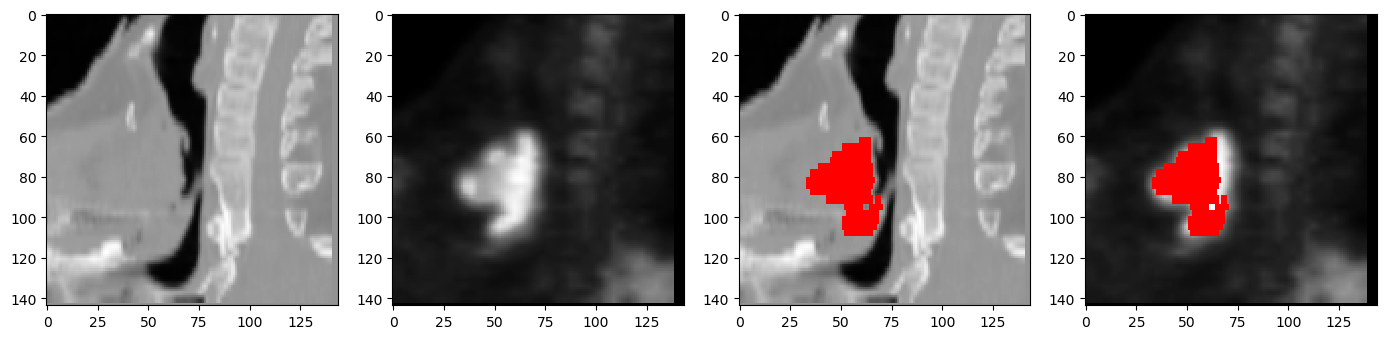

In [13]:
s = 75

plt.rcdefaults()
palette = copy(plt.cm.Greys_r)
palette.set_bad(color='r', alpha=1)  # set color for the mask

fig, axes = plt.subplots(1, 4, figsize=(14, 10))
axes[0].imshow(img_ct[:, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[1].imshow(img_pt[:, :, s], cmap=plt.cm.Greys_r, interpolation='none')
axes[2].imshow(img_ct_mask[:, :, s], cmap=palette, interpolation='none')
axes[3].imshow(img_pt_mask[:, :, s], cmap=palette, interpolation='none')
plt.tight_layout()
plt.show()